In [1]:
# A script to export the reactions from an RMG mechanism and the database
# produces 3 files:

# make a dict entry for index

# species_dict_file = 'species_dict.pickle'
# reaction_dict_file = 'reaction_dict.pickle'

# correlated_uncertainty_file = 'correlated_uncertainty.pickle'


In [2]:
# example script to show how to unpack information in pickled files
import pickle
import numpy as np

In [3]:
import os
import copy
import itertools
import numpy as np
import scipy.stats
import rmgpy.data.thermo
import rmgpy.data.rmg
import rmgpy.chemkin
import rmgpy.exceptions

import rmgpy.tools.uncertainty
import matplotlib.pyplot as plt
%matplotlib inline


import importlib
importlib.reload(rmgpy.tools.uncertainty)

<module 'rmgpy.tools.uncertainty' from '/home/moon/rmg/RMG-Py/rmgpy/tools/uncertainty.py'>

In [4]:
# load example 

gas_chemkin = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20241020/chem_annotated-gas.inp'
gas_surface = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20241020/chem_annotated-surface.inp'
sp_dict = '/home/moon/uncertainty_estimator/cpox_pt/cpox_pt_20241020/species_dictionary.txt'
test_species_list, test_reaction_list = rmgpy.chemkin.load_chemkin_file(gas_chemkin, sp_dict, surface_path=gas_surface)

In [5]:
type(test_reaction_list[-1])

rmgpy.data.kinetics.family.TemplateReaction

In [6]:
# Load the database
database = rmgpy.data.rmg.RMGDatabase()
database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = ['surfaceThermoPt111', 'primaryThermoLibrary'],
    reaction_libraries = ['Surface/CPOX_Pt/Deutschmann2006_adjusted'],
#     kinetics_families = ['Surface_Abstraction'],
    kinetics_families = ['surface'],
    kinetics_depositories = ['training'],
    depository = True,
)

In [7]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return -1

## Manually add other reactions

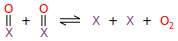

In [8]:
display(test_reaction_list[50])

manual_additions = [test_reaction_list[50]]


In [9]:
test_reaction_list[50].products[1].thermo

NASA(polynomials=[NASAPolynomial(coeffs=[0.00710137,-4.25617e-05,8.98527e-08,-7.80188e-11,2.32464e-14,-0.8761,-0.031121], Tmin=(100,'K'), Tmax=(1554.8,'K')), NASAPolynomial(coeffs=[0.160301,-0.000252236,1.14182e-07,-1.21473e-11,3.85799e-16,-70.8105,-0.909532], Tmin=(1554.8,'K'), Tmax=(5000,'K'))], Tmin=(100,'K'), Tmax=(5000,'K'), comment="""Thermo library: surfaceThermoPt111 Binding energy corrected by LSR () from Pt111""")

In [10]:
# Collect all of the training reactions

reaction_list = []
species_list = []  # build this up as you go to make sure all reactions use the same species object
for family in database.kinetics.families.keys():
    training_depository = database.kinetics.families[family].get_training_depository()
    for i, entry in enumerate(training_depository.entries):
        my_reaction = rmgpy.data.kinetics.family.TemplateReaction()
        my_reaction.reactants = training_depository.entries[entry].item.reactants
        my_reaction.products = training_depository.entries[entry].item.products
        my_reaction.family = family

        try:
            template_labels = database.kinetics.families[family].get_reaction_template_labels(my_reaction)
            template = database.kinetics.families[family].retrieve_template(template_labels)
            kinetics = database.kinetics.families[family].get_kinetics_for_template(template, degeneracy=my_reaction.degeneracy)[0]
            my_reaction.kinetics = kinetics
        except:
            continue
        reaction_list.append(my_reaction)
    
# add the other miscellaneous LIBRARY reactions
for i in range(len(manual_additions)):
    manual_additions[i].kinetics.comment += 'Library ' + manual_additions[i].family
    reaction_list.append(manual_additions[i])
print(len(reaction_list))


45


In [39]:
'234'.endswith('4')

True

In [42]:
ord('9')

57

In [49]:
def increment_label(old_label):
    if len(old_label) >= 2:
        if '_' in old_label:
            tokens = old_label.split('_')
            try:
                old_num = int(tokens[-1])
                return old_label[:-len(tokens[-1])] + str(old_num + 1)
            except ValueError:
                pass
        elif '-' in old_label:
            tokens = old_label.split('-')
            try:
                old_num = int(tokens[-1])
                return old_label[:-len(tokens[-1])] + str(old_num + 1)
            except ValueError:
                pass
            
    return old_label + '_2'

In [51]:
increment_label('A-9')

'A-10'

In [54]:
species_list = []


for i in range(len(reaction_list)):
     for j in range(len(reaction_list[i].reactants)):
        i_thing = get_i_thing(reaction_list[i].reactants[j], species_list)
        if i_thing < 0:
            reaction_list[i].reactants[j].thermo = database.thermo.get_thermo_data(reaction_list[i].reactants[j])
            new_sp = reaction_list[i].reactants[j]
            while new_sp.label in [sp.label for sp in species_list]:
                new_sp.label = increment_label(new_sp.label)
            species_list.append(new_sp)
        else:
            reaction_list[i].reactants[j] = species_list[i_thing]  # reuse species objects

for i in range(len(reaction_list)):
    for j in range(len(reaction_list[i].products)):
        i_thing = get_i_thing(reaction_list[i].products[j], species_list)
        if i_thing < 0:
            reaction_list[i].products[j].thermo = database.thermo.get_thermo_data(reaction_list[i].products[j])
            new_sp = reaction_list[i].products[j]
            while new_sp.label in [sp.label for sp in species_list]:
                new_sp.label = increment_label(new_sp.label)
            species_list.append(new_sp)
        else:
            reaction_list[i].products[j] = species_list[i_thing]  # reuse species objects
        

In [55]:
len(reaction_list)

45

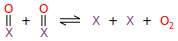

In [56]:
reaction_list[-1]

In [57]:
len(species_list)

49

In [58]:
len(species_list)

49

In [59]:
for i in range(len(species_list)):
    for j in range(i):
        if species_list[i].is_isomorphic(species_list[j]):
            print(i, j)
        if species_list[i].label == species_list[j].label:
            print(i, j)

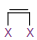

In [60]:
species_list[39]

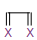

In [61]:
species_list[19]

In [62]:
# for i in range(len(reaction_list)):
#     print(reaction_list[i].is_surface_reaction(), reaction_list[i])

In [63]:
# Trim the set to just surface reactions and the species reacting in them
# Per Joy's request, make sure to only include species involved in reactions
surface_only = True

reacting_species_set = set()
for i in range(len(reaction_list)):
    if surface_only and not reaction_list[i].is_surface_reaction():
        continue
    for sp in reaction_list[i].reactants + reaction_list[i].products:
        reacting_species_set.add(species_list.index(sp))
include_species_list = [species_list[i] for i in reacting_species_set]



include_reactions_set = set()
for i in range(len(reaction_list)):
    if surface_only and not reaction_list[i].is_surface_reaction():
        continue
    include_reactions_set.add(i)
include_reactions_list = [reaction_list[i] for i in include_reactions_set]



In [64]:
[sp.label for sp in include_species_list]

['CH2X_1',
 'HOX_3',
 'CHX_1',
 'CX_1',
 'OX_1',
 'HCOX_3',
 'H2O*',
 'CH4*',
 'HCCH',
 'X_3',
 'H2CCH2',
 'H2CO',
 'H2',
 'NO',
 'H2O',
 'CO2',
 'CH4',
 'CC_2X',
 'CCH_2X',
 'HCCH_2X',
 'HCCH2_2X',
 'HOCXO_1',
 'NH2_X',
 'NHX_2',
 'HCOO*',
 'CH3O2*',
 'H2CCH2_2X',
 'H2CO_2X',
 'HCOOH*',
 'H2CCH3_X',
 'HCCH3_X',
 'NH3_X',
 'XCCH2',
 'XCHCH2',
 'HCCHX_vdW',
 'H2CCH2X_vdW',
 'H2COX_vdW',
 'CH3X_4',
 'COX_5',
 'HCCH_2X_2',
 'HX_3',
 'NO_X',
 'CO2X',
 'NX',
 'CH2OH*_2',
 'HCO_2X',
 'XCXCH2_3',
 'HCOH*',
 'O2']

In [65]:
len(include_species_list)

49

In [66]:
for i in include_reactions_list:
    print(i)

CH2X_1 + HOX_3 <=> CH3X_4 + OX_1
CHX_1 + HOX_3 <=> CH2X_1 + OX_1
CX_1 + HOX_3 <=> CHX_1 + OX_1
OX_1 + HCOX_3 <=> HOX_3 + COX_5
H2O* + OX_1 <=> HOX_3 + HOX_3
CH4* + OX_1 <=> CH3X_4 + HOX_3
HCCH + X_3 + X_3 <=> HCCH_2X_2
H2CCH2 + X_3 + X_3 <=> H2CCH2_2X
H2CO + X_3 + X_3 <=> H2CO_2X
H2 + X_3 + X_3 <=> HX_3 + HX_3
H2 + X_3 + X_3 <=> HX_3 + HX_3
NO + X_3 <=> NO_X
H2O + X_3 <=> H2O*
CO2 + X_3 <=> CO2X
CH4 + X_3 <=> CH4*
CC_2X <=> CX_1 + CX_1
CCH_2X <=> CX_1 + CHX_1
HCCH_2X <=> CHX_1 + CHX_1
HCCH2_2X <=> CHX_1 + CH2X_1
HOCXO_1 + X_3 <=> COX_5 + HOX_3
NH2_X + X_3 <=> NHX_2 + HX_3
NHX_2 + X_3 <=> NX + HX_3
HCOO* + X_3 <=> HCOX_3 + OX_1
HOX_3 + X_3 <=> OX_1 + HX_3
HOX_3 + X_3 <=> OX_1 + HX_3
CH3O2* + X_3 <=> CH2OH*_2 + OX_1
HCOX_3 + X_3 <=> COX_5 + HX_3
HCCH2_2X + X_3 <=> HCCH_2X + HX_3
H2CCH2_2X + X_3 <=> HCCH2_2X + HX_3
H2CO_2X + X_3 <=> HCO_2X + HX_3
HCCH2_2X + X_3 <=> XCXCH2_3 + HX_3
HCOOH* + X_3 <=> HCOH* + OX_1
H2CCH3_X + X_3 + X_3 <=> H2CCH2_2X + HX_3
HCCH3_X + X_3 + X_3 <=> HCCH2_2X + HX

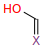

In [67]:
include_species_list[-2]

In [68]:
len(include_species_list)

49

# Fill out the species dictionary

In [69]:
species_dict = {}
for i in range(len(include_species_list)):
    print(i, include_species_list[i])
    species_label = include_species_list[i].to_chemkin()
    
    if type(include_species_list[i].thermo) == rmgpy.thermo.thermodata.ThermoData:
        include_species_list[i].thermo = include_species_list[i].thermo.to_nasa(
            np.min(include_species_list[i].thermo.Tdata.value_si),
            np.max(include_species_list[i].thermo.Tdata.value_si),
            np.mean(include_species_list[i].thermo.Tdata.value_si)
        )
    
    species_entry = {
        'index': i,
        'RMG_adjacency_list': include_species_list[i].to_adjacency_list(),
        'NASA0': {
            'coeffs': include_species_list[i].thermo.polynomials[0].coeffs,
            'Tmin': include_species_list[i].thermo.polynomials[0].Tmin.value_si,
            'Tmax': include_species_list[i].thermo.polynomials[0].Tmax.value_si
        },
        'NASA1': {
            'coeffs': include_species_list[i].thermo.polynomials[1].coeffs,
            'Tmin': include_species_list[i].thermo.polynomials[1].Tmin.value_si,
            'Tmax': include_species_list[i].thermo.polynomials[1].Tmax.value_si
        },
        'comment': include_species_list[i].thermo.comment
    }
    
    species_dict[species_label] = species_entry



0 CH2X_1
1 HOX_3
2 CHX_1
3 CX_1
4 OX_1
5 HCOX_3
6 H2O*
7 CH4*
8 HCCH
9 X_3
10 H2CCH2
11 H2CO
12 H2
13 NO
14 H2O
15 CO2
16 CH4
17 CC_2X
18 CCH_2X
19 HCCH_2X
20 HCCH2_2X
21 HOCXO_1
22 NH2_X
23 NHX_2
24 HCOO*
25 CH3O2*
26 H2CCH2_2X
27 H2CO_2X
28 HCOOH*
29 H2CCH3_X
30 HCCH3_X
31 NH3_X
32 XCCH2
33 XCHCH2
34 HCCHX_vdW
35 H2CCH2X_vdW
36 H2COX_vdW
37 CH3X_4
38 COX_5
39 HCCH_2X_2
40 HX_3
41 NO_X
42 CO2X
43 NX
44 CH2OH*_2
45 HCO_2X
46 XCXCH2_3
47 HCOH*
48 O2(3)


In [70]:
len(species_dict)

49

In [71]:
species_dict_file = 'species_dict.pickle'
with open(species_dict_file, 'wb') as f:
    pickle.dump(species_dict, f)

In [72]:
# read back in to check
with open(species_dict_file, 'rb') as f:
    my_data = pickle.load(f)


In [73]:
len(my_data)

49

# Fill out the reaction dictionary

In [74]:
reaction_dict = {}
N = len(species_dict)
for i in range(len(include_reactions_list)):
    reaction_label = str(include_reactions_list[i])
    
    
    if type(include_reactions_list[i].kinetics) in [rmgpy.kinetics.surface.SurfaceArrheniusBEP, rmgpy.kinetics.surface.StickingCoefficientBEP]:
        kinetic_entry = {
            'A': include_reactions_list[i].kinetics.A.value,
            'n': include_reactions_list[i].kinetics.n.value,
            'alpha': include_reactions_list[i].kinetics.alpha.value,
            'E0': include_reactions_list[i].kinetics.E0.value,
            'A_units': include_reactions_list[i].kinetics.A.units,
            'E0_units': include_reactions_list[i].kinetics.E0.units
        }
    elif type(include_reactions_list[i].kinetics) in [rmgpy.kinetics.surface.SurfaceArrhenius, rmgpy.kinetics.surface.StickingCoefficient]:
        kinetic_entry = {
            'A': include_reactions_list[i].kinetics.A.value,
            'n': include_reactions_list[i].kinetics.n.value,
            'Ea': include_reactions_list[i].kinetics.Ea.value,
            'A_units': include_reactions_list[i].kinetics.A.units,
            'Ea_units': include_reactions_list[i].kinetics.Ea.units
        }
    
    reaction_entry = {
        'index': N + i,
        'parameterization': str(type(include_reactions_list[i].kinetics)),
        'kinetics': kinetic_entry,
        'comment': include_reactions_list[i].kinetics.comment,
        'reactants': [str(include_reactions_list[i].reactants[j].to_chemkin()) for j in range(len(include_reactions_list[i].reactants))],
        'products': [str(include_reactions_list[i].products[j].to_chemkin()) for j in range(len(include_reactions_list[i].products))],
    }
    
    reaction_dict[reaction_label] = reaction_entry


In [75]:
reaction_dict_file = 'reaction_dict.pickle'
with open(reaction_dict_file, 'wb') as f:
    pickle.dump(reaction_dict, f)

In [76]:
# read back in to check
with open(reaction_dict_file, 'rb') as f:
    my_data = pickle.load(f)


In [77]:
my_data['OX_1 + OX_1 <=> X_3 + X_3 + O2(3)']

{'index': 93,
 'parameterization': "<class 'rmgpy.kinetics.surface.SurfaceArrhenius'>",
 'kinetics': {'A': 3.7e+21,
  'n': 0.0,
  'Ea': 66.611,
  'A_units': 'cm^2/(mol*s)',
  'Ea_units': 'kcal/mol'},
 'comment': 'Library Surface/CPOX_Pt/Deutschmann2006_adjusted',
 'reactants': ['OX_1', 'OX_1'],
 'products': ['X_3', 'X_3', 'O2(3)']}

In [78]:
rmgpy.chemkin.save_species_dictionary('species_dictionary.txt', species_list)

In [79]:
rmgpy.chemkin.save_chemkin_file('my_reactions.inp', species_list, reaction_list)

# Run uncertainty Analysis

In [80]:
uncertainty = rmgpy.tools.uncertainty.Uncertainty(species_list=species_list, reaction_list=reaction_list)

In [81]:
# uncertainty = rmgpy.tools.uncertainty.Uncertainty()
# uncertainty.load_model('my_reactions.inp', 'species_dictionary.txt', transport_path=None, surface_path=None)

In [82]:
len(uncertainty.species_list)

49

In [83]:
len(uncertainty.reaction_list)

45

In [84]:
uncertainty.database = database

In [85]:
uncertainty.extract_sources_from_model()

In [86]:
uncertainty.assign_parameter_uncertainties(correlated=True)

In [87]:
uncertainty.get_thermo_covariance_matrix()

array([[47.858724,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , 47.858724,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 47.858724, ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 47.858724,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      , 47.858724,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         2.25    ]])

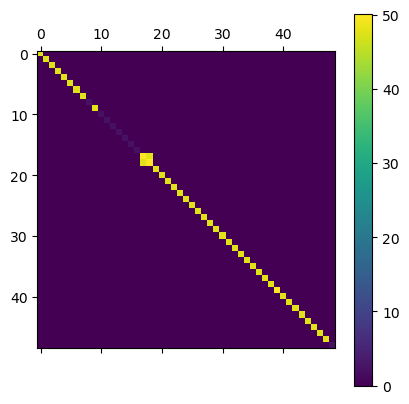

In [88]:
# Show the thermo covariance matrix
plt.matshow(uncertainty.thermo_covariance_matrix)
plt.colorbar()

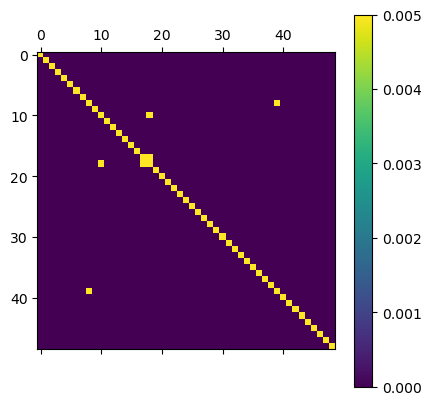

In [89]:
# Zoom in to see which parameters are correlated: the answer is not many -- onyl a handful of similar gorups
plt.matshow(uncertainty.thermo_covariance_matrix)
plt.colorbar()
plt.clim([0, 0.005])

# Now do kinetics covariance

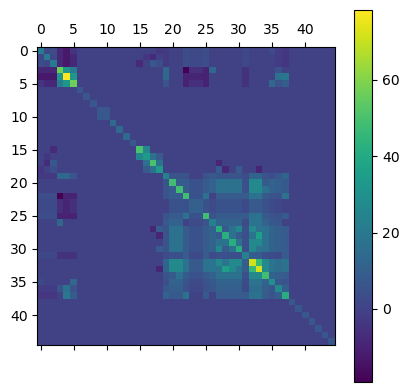

In [90]:
uncertainty.get_kinetic_covariance_matrix()
# Show the kinetics covariance matrix
plt.matshow(uncertainty.kinetic_covariance_matrix)
plt.colorbar()

In [91]:
delta_ln_k = np.sqrt(np.max(uncertainty.kinetic_covariance_matrix))  # that's 1 std dev ln k

# which corresponds to kmax/k of
np.exp(delta_ln_k * np.sqrt(3))

# 6.7 orders of magnitude. Okay. For the worst case scenario, yeah...
np.log10(np.exp(delta_ln_k * np.sqrt(3)))

6.655543823643739

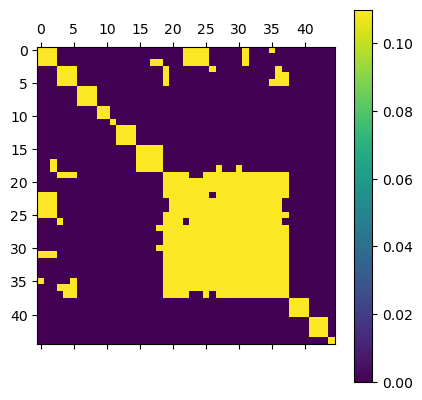

In [92]:
# zoom in to highlight correlations
plt.matshow(uncertainty.kinetic_covariance_matrix)
plt.colorbar()
plt.clim([0, 0.11])

In [93]:
uncertainty.kinetic_covariance_matrix[:, -1]

array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 7.070281])

In [94]:
uncertainty.overall_covariance_matrix[:, -1]

TypeError: 'NoneType' object is not subscriptable

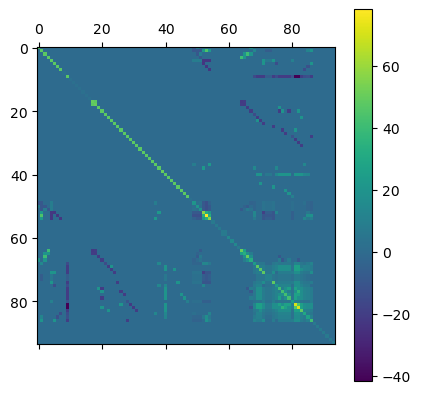

In [95]:
uncertainty.get_overall_covariance_matrix()
plt.matshow(uncertainty.overall_covariance_matrix)
plt.colorbar()

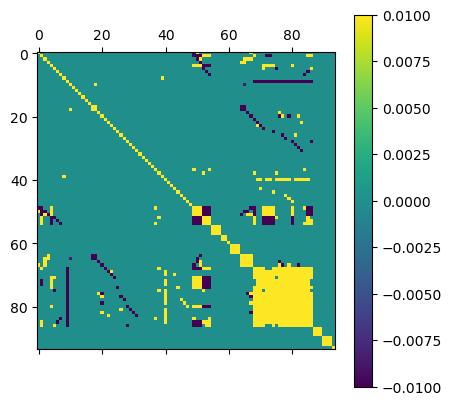

In [96]:
uncertainty.get_overall_covariance_matrix()
plt.matshow(uncertainty.overall_covariance_matrix)
plt.colorbar()
plt.clim([-0.01, 0.01])

In [97]:
np.save('thermo_cov.npy', uncertainty.thermo_covariance_matrix)
np.save('kinetic_cov.npy', uncertainty.kinetic_covariance_matrix)
np.save('overall_cov.npy', uncertainty.overall_covariance_matrix)

In [ ]:
np.sqrt(uncertainty.kinetic_covariance_matrix[0,0])

In [ ]:
for i in range(len(reaction_list)):
    print(f'{i}\t{np.sqrt(uncertainty.kinetic_covariance_matrix[i, i])}\t{reaction_list[i]}')

In [ ]:
uncertainty.thermo_covariance_matrix[0,0] * 4184 * 4184

In [ ]:
varH = np.float_power(28945.5, 2.0)

In [ ]:
varH

In [ ]:
type(uncertainty.reaction_list[10].kinetics)